# Image classification from scratch 

### This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset. 

## Setup  

### import all libraries that we need 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data : the Cats vs Dogs

### get the data from kaggle

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 1486k    0     0  1216k      0  0:11:02  0:00:01  0:11:01 1217k
  0  786M    0 5457k    0     0  2455k      0  0:05:28  0:00:02  0:05:26 2457k
  1  786M    1 9022k    0     0  2798k      0  0:04:47  0:00:03  0:04:44 2799k
  1  786M    1 12.4M    0     0  3025k      0  0:04:26  0:00:04  0:04:22 3025k
  2  786M    2 15.8M    0     0  3108k      0  0:04:19  0:00:05  0:04:14 3262k
  2  786M    2 19.5M    0     0  3224k      0  0:04:09  0:00:06  0:04:03 3715k
  2  786M    2 23.1M    0     0  3284k      0  0:04:05  0:00:07  0:03:58 3653k
  3  786M    3 27.0M    0     0  3349k      0  0:04:00  0:00:08  0:03:52 3702k
  3  786M    3 30.4M    0     0  3383k      0  0:03

In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls


 60  786M   60  473M    0     0  4132k      0  0:03:14  0:01:57  0:01:17 5274k
 60  786M   60  476M    0     0  4123k      0  0:03:15  0:01:58  0:01:17 4849k
 61  786M   61  480M    0     0  4130k      0  0:03:15  0:01:59  0:01:16 4751k
 61  786M   61  485M    0     0  4137k      0  0:03:14  0:02:00  0:01:14 4681k
 62  786M   62  490M    0     0  4139k      0  0:03:14  0:02:01  0:01:13 4464k
 62  786M   62  495M    0     0  4148k      0  0:03:14  0:02:02  0:01:12 4541k
 63  786M   63  500M    0     0  4156k      0  0:03:13  0:02:03  0:01:10 4937k
 64  786M   64  505M    0     0  4164k      0  0:03:13  0:02:04  0:01:09 4970k
 64  786M   64  510M    0     0  4170k      0  0:03:13  0:02:05  0:01:08 4958k
 65  786M   65  513M    0     0  4146k      0  0:03:14  0:02:06  0:01:08 4302k
 65  786M   65  516M    0     0  4154k      0  0:03:13  0:02:07  0:01:06 4291k
 66  786M   66  519M    0     0  4148k      0  0:03:14  0:02:08  0:01:06 3956k
 66  786M   66  523M    0     0  4149k      0  0:03

### The folder that contain Two subfolder contains image files for each category. 

In [4]:
!ls PetImages

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Filter out corrupted images 

#### filter out badly-encoded images that do not feature the string "JFIF" in their header 

In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate a Dataset

In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


## Visualize the Data

### the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat" 

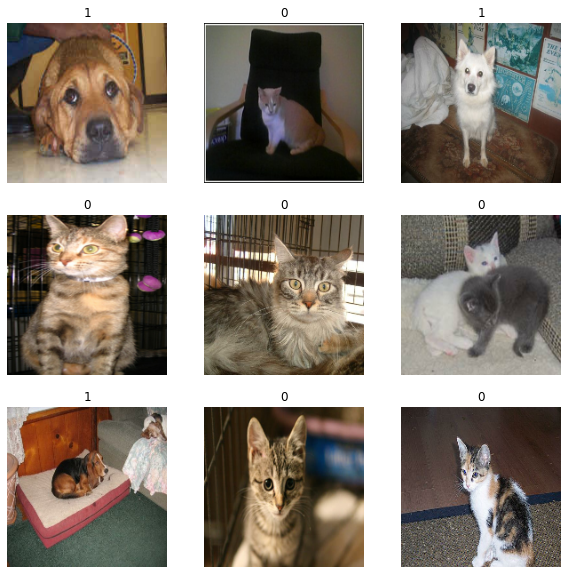

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augemention

#### This helps expose the model to different aspects of the training data while slowing down overfitting 

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

###  visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset 

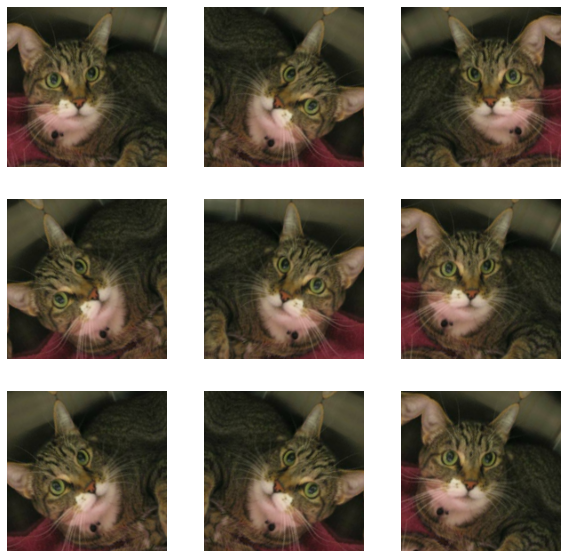

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data 

###  Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model 

## Two options to preprocess the data

### There are two ways you could be using the data_augmentation preprocessor:

### Option 1: Make it part of the model, 

In [8]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

NameError: name 'input_shape' is not defined

### option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images 

In [9]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

## Configure the dataset for perfomance

#### Apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking 

In [11]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


## Build a model 

### build a small version of the Xception network. We haven't particularly tried to optimize the architecture 

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train the model

In [13]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


KeyboardInterrupt: 

## Run inference on new data 

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

## Conclusion
At the end of training we get to >90% validation accuracy after training for 25 epochs on the full dataset . and we can notice  from this lab how we can increase our dataset  when we don't have a large image dataset, we can artificially introduce sample diversity by applying random yet realistic transformations to the training images,  helps expose the model to different aspects of the training data while slowing down overfitting.